# Non-negative integration of  gene expression and chromatin accessibility of 10k PBMCs

This notebook demonstrates how to apply a non-negative version (experimental) of `MuVI` on multiple modalities, e.g. RNA-seq and ATAC-seq, in order to infer a joint latent space that is informed a priori by existing domain knowledge in terms of gene set annotations.

This tutorial extends the excellent [muon-tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/3-Multimodal-Omics-Data-Integration.html) on applying [MOFA](https://biofam.github.io/MOFA2/) to single-cell gene expression and chromatin accessibility for inferring a joint latent space across multiple modalities.
Please refer to [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/1-Gene-Expression-Processing.html) for processing the RNA modality, and [this tutorial](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html) for processing the ATAC modality.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu

<IPython.core.display.Javascript object>

In [3]:
import muvi

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7fbaaee7af20>


<IPython.core.display.Javascript object>

In [5]:
# plotting settings
sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

<IPython.core.display.Javascript object>

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
try:
    gpu_idx = muvi.get_free_gpu_idx()
    print("Using GPU #%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU #3


<IPython.core.display.Javascript object>

Load the MuData object from the `.h5mu` file:

In [7]:
mdata = mu.read("../../../data/pbmc10k.h5mu")
# use only cells that are present for both modalities
mu.pp.intersect_obs(mdata)
mdata

MuData object with n_obs × n_vars = 9534 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
  2 modalities
    atac:	9534 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'atac', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    rna:	9534 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'connectivities', 'distances'

<IPython.core.display.Javascript object>

In [8]:
# work with log-normalised counts
ad_dict = {}
for k, adata in mdata.mod.items():
    _adata = adata.raw.to_adata()
    _adata.X = _adata.X.todense()
    ad_dict[k] = _adata
mdata = mu.MuData(ad_dict)
mdata

MuData object with n_obs × n_vars = 9534 × 132435
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    atac:	9534 x 106086
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      obsp:	'connectivities', 'distances'
    rna:	9534 x 26349
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      obsp:	'connectivities', 'distances'

<IPython.core.display.Javascript object>

<AxesSubplot: >

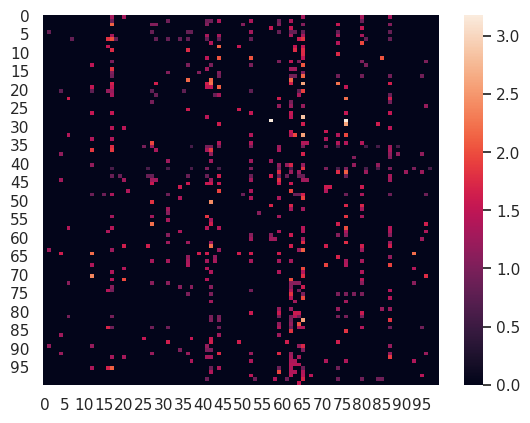

<IPython.core.display.Javascript object>

In [9]:
# visual check
sns.heatmap(mdata["rna"].X[:100, :100])

<AxesSubplot: >

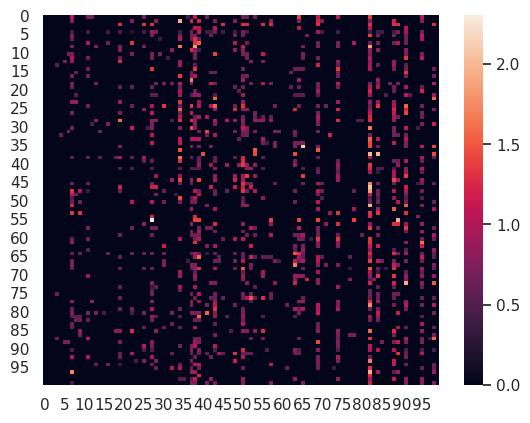

<IPython.core.display.Javascript object>

In [10]:
sns.heatmap(mdata["atac"].X[:100, :100])

## Multimodal Integration

In [11]:
# subset only highly variable features
mu.pp.filter_var(mdata, "highly_variable")
mdata

MuData object with n_obs × n_vars = 9534 × 17922
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    atac:	9534 x 14896
      obs:	'n_genes_by_counts', 'total_counts', 'NS', 'n_counts', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'atac', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      obsp:	'connectivities', 'distances'
    rna:	9534 x 3026
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
      obsm:	'X_pca', 'X_umap'
      obsp:	'connectivities', 'distances'

<IPython.core.display.Javascript object>

Perform a simple preprocessing by centering the data and keeping only the 6000 most variable genes from the RNA-seq dataset, instead of ~15K. Finally, update the `MuData` object.

In [12]:
top_k_var = 6000
for view_name, adata in mdata.mod.items():
    ordered_feature_subset = np.nanvar(adata.X, axis=0).argsort()[::-1]
    print(
        f"Ordering features by variance in descending order, and keeping only top {top_k_var}"
    )
    adata._inplace_subset_var(adata.var_names[ordered_feature_subset[:top_k_var]])

    print(f"Current shape of {view_name}: {adata.shape}")
    global_std = np.nanstd(adata.X)
    print(f"Global std of {view_name} before: {global_std}")
    adata.X /= global_std
    print(f"Global std of {view_name}: {np.nanstd(adata.X)}")

mdata.update()

Ordering features by variance in descending order, and keeping only top 6000


/tmp/ipykernel_1242500/355854850.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  adata._inplace_subset_var(adata.var_names[ordered_feature_subset[:top_k_var]])


Current shape of atac: (9534, 14896)
Global std of atac before: 0.2954351007938385
Global std of atac: 0.9999974966049194
Ordering features by variance in descending order, and keeping only top 6000


/tmp/ipykernel_1242500/355854850.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  adata._inplace_subset_var(adata.var_names[ordered_feature_subset[:top_k_var]])


Current shape of rna: (9534, 3026)
Global std of rna before: 0.5290766954421997
Global std of rna: 0.9999998807907104


<IPython.core.display.Javascript object>

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [13]:
gene_set_collection = muvi.fs.from_gmt(
    "../msigdb/c8.all.v7.5.1.symbols.gmt", name="celltype"
)
gene_set_collection

<FeatureSets 'celltype' with 700 feature sets>

<IPython.core.display.Javascript object>

To reduce the number of feature sets to more specific ones for our dataset, we filter for blood and bone related cell types only.

In [14]:
gene_set_collection = gene_set_collection.find("BLOOD") | gene_set_collection.find(
    "BONE"
)
gene_set_collection

<FeatureSets 'celltype:BLOOD|celltype:BONE' with 41 feature sets>

<IPython.core.display.Javascript object>

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [15]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15
)
gene_set_collection

<FeatureSets 'celltype:BLOOD|celltype:BONE' with 24 feature sets>

<IPython.core.display.Javascript object>

Generally, the gene set collections inform different views differently. That is, some gene sets may inform a single view only, while other gene sets inform both views jointly. Therefore, we store the prior information into the corresponding `AnnData` inside the `MuData` object. 

In our case, we may only inform the RNA view, and expect the ATAC view to be informed implicitly during the inference of shared latent factors.

Finally, we convert the prior information into a numerical representation such as a binary matrix.

In [16]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    adata.var_names.tolist()
).T

<IPython.core.display.Javascript object>

Create a `MuVI` model directly from the `MuData` object by providing the necessary arguments such as the `varm` key for the numerically encoded prior information of the gene set annotations.

In [17]:
# set `nmf=True` for both views to enforce the non-negative constraint
model = muvi.tl.from_mdata(
    mdata,
    prior_mask_key="gene_set_mask",
    view_names=["rna", "atac"],
    nmf={"rna": True, "atac": True},
)

2023-05-31 17:16:48,679 - muvi.tools.utils - WARNING - No prior information found for `atac`.
2023-05-31 17:16:48,682 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-31 17:16:48,683 - muvi.core.models - INFO - Storing the index of the view `rna` as sample names.
2023-05-31 17:16:48,684 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-31 17:16:48,687 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-31 17:16:48,687 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-31 17:16:48,688 - muvi.core.models - INFO - pd.DataFrame detected.
2023-05-31 17:16:48,689 - muvi.core.models - INFO - Storing the index of the mask `rna` as factor names.
2023-05-31 17:16:48,691 - muvi.core.models - INFO - Mask for view `atac` not found, assuming `atac` to be uninformed.
2023-05-31 17:16:48,697 - muvi.core.models - INFO - Likelihoods set to `{'rna': 'normal', 'atac': 'normal'}`.
2023-05-31 17:16:48,698 - muvi.core.models - INFO - NMF set to `{'rna': True, 'atac': True}`.

<IPython.core.display.Javascript object>

Train the model using stochastic variational inference (SVI) in order to utilize smaller batches of the whole dataset to avoid loading the whole dataset onto the GPU. The training takes around 7 minutes on a single Quadro RTX 5000 NVIDIA GPU.

In [18]:
n_epochs = 500
model.fit(
    batch_size=1000,
    n_epochs=n_epochs,
    n_particles=1,
    learning_rate=0.005,
    optimizer="clipped",
    verbose=1,
    seed=0,
)

2023-05-31 17:16:48,712 - muvi.core.models - INFO - Preparing model and guide...
2023-05-31 17:16:48,732 - muvi.core.models - INFO - Preparing optimizer...
2023-05-31 17:16:48,733 - muvi.core.models - INFO - Decaying learning rate over 4500 iterations.
2023-05-31 17:16:48,734 - muvi.core.models - INFO - Preparing SVI...
2023-05-31 17:16:48,735 - muvi.core.models - INFO - Preparing training data...
2023-05-31 17:16:48,973 - muvi.core.models - INFO - Using batches of size `1000`.
2023-05-31 17:16:48,975 - muvi.core.models - INFO - Setting training seed to `0`.
2023-05-31 17:16:48,975 - muvi.core.models - INFO - Cleaning parameter store.
2023-05-31 17:16:48,976 - muvi.core.models - INFO - Starting training...


  0%|                                                                                                                                      | 0/500 [00:00<?, ?it/s]

2023-05-31 17:16:49,831 - root - INFO - Guessed max_plate_nesting = 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:18<00:00,  1.14it/s, ELBO=1.97e+5]

2023-05-31 17:24:07,412 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


<IPython.core.display.Javascript object>

## Downstream Analysis

Once the training terminates, we may call `muvi.tl.foo` followed by `muvi.pl.foo` to apply different analysis tools and plot the results, similar to the usage principles of `scanpy`.

Under the hood, `muvi` stores every intermediate result in a `model._cache.factor_adata` such as variance explained by each factor, significance of each factor with respect to the prior information and so on.

In [19]:
# first, lets prettify the names of the factors
old_factor_names = model.factor_names
model.factor_names = (
    model.factor_names.str.split("_").str[3:].str.join(" ").str.title().str[:40]
)

<IPython.core.display.Javascript object>

2023-05-31 17:24:07,486 - muvi.tools.utils - INFO - Estimating `r2` with a random sample of 1000 samples.
2023-05-31 17:24:07,733 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


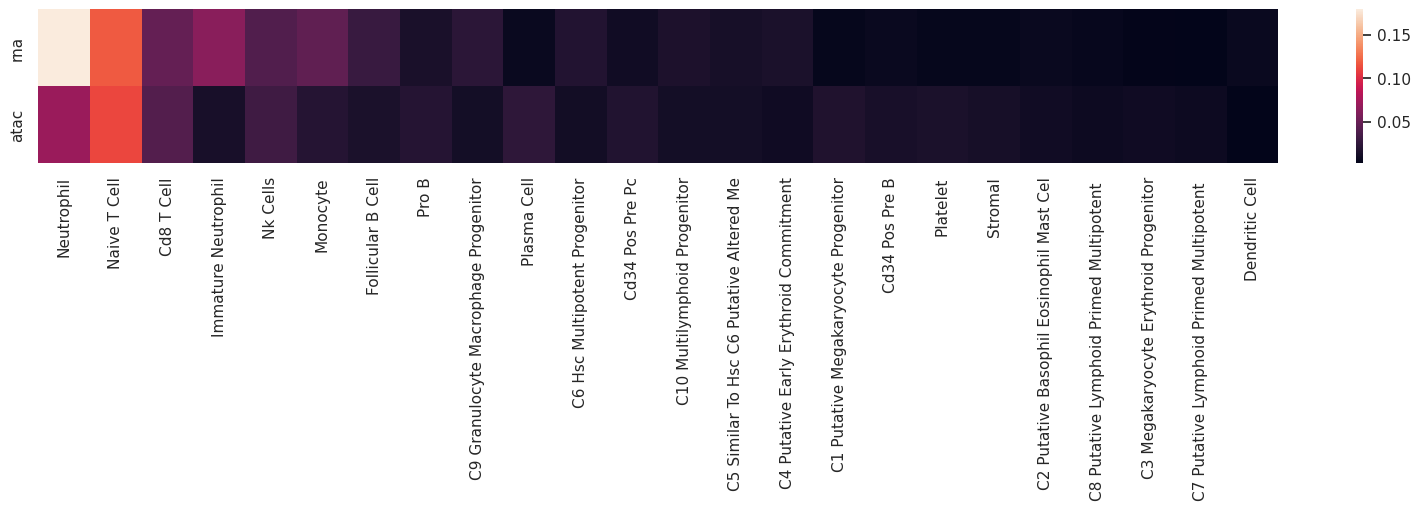

<AxesSubplot: >

<IPython.core.display.Javascript object>

In [20]:
# to speed up the process, use a random subsample to approximate the variance explained
muvi.tl.variance_explained(model, subsample=1000)
muvi.pl.variance_explained(model)

Next, we perform a statistical test ([PCGSE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4543476/)) to determine how well the inferred factors match the prior information representing each pathway. Here, we apply a correlation adjusted one-sided t-test, and correcting for multiple testing. 

Unless we provide other feature sets, e.g. [Gene Ontology](http://geneontology.org/), `muvi` automatically compares each inferred factor against its corresponding prior gene set annotation. Since we only inform the RNA view, we may not apply this function on the uninformed views such as the ATAC view in our case.

In [21]:
for sign in ["neg", "pos"]:
    muvi.tl.test(model, view_idx="rna", sign=sign)

2023-05-31 17:24:13,966 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 14.00it/s]


2023-05-31 17:24:15,818 - muvi.tools.utils - WARNING - No feature sets provided, extracting feature sets from prior mask.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.80it/s]


<IPython.core.display.Javascript object>

Now we may plot an overview of the most relevant factors by combining the variance explained and the results of the statistical test. Since we applied a one-sided hypothesis test, each significant factor is marked by a `(+)` or `(-)` indicating the significance direction. A factor may also be significant in both directions. However, we report the more significant direction based on the lower p-value.

For the uninformed views, i.e. ATAC, we omit any information regarding the statistical testing, and only sort the factors by their corresponding variance explained.

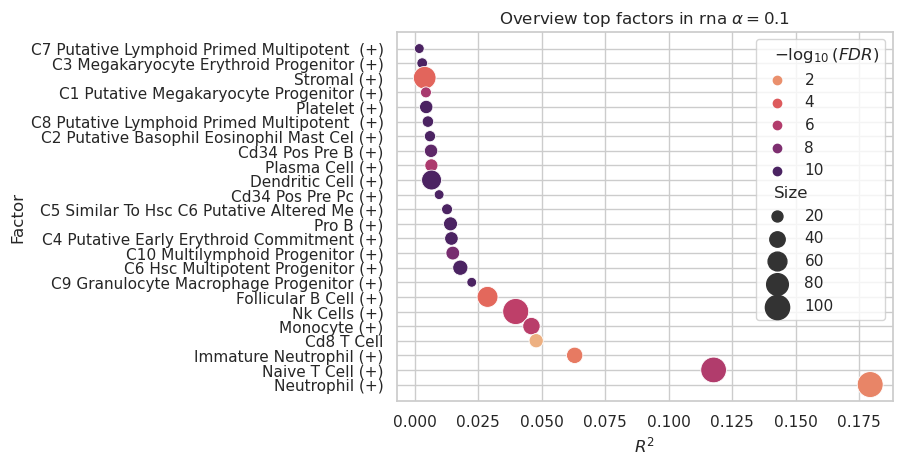

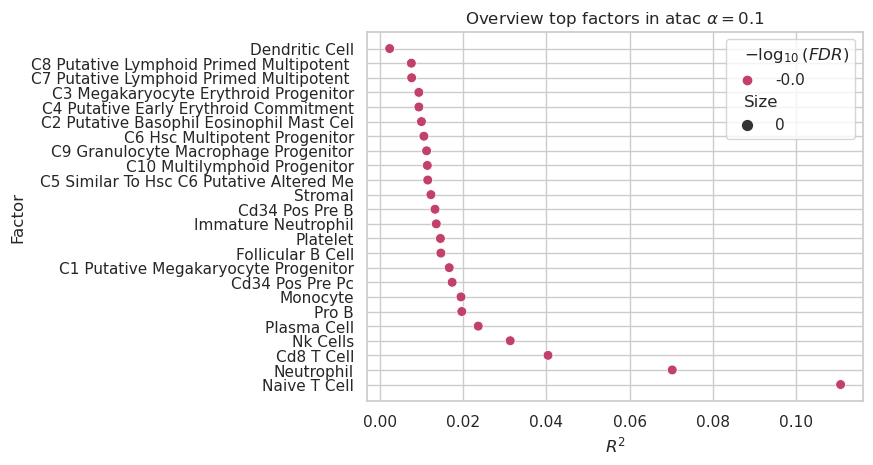

<IPython.core.display.Javascript object>

In [22]:
for vn in model.view_names:
    muvi.pl.factors_overview(
        model,
        vn,
        one_sided=True,
        alpha=0.1,
        sig_only=False,
        adjusted=True,
        top=25,
        show=True,
    )

In [23]:
# add obs metadata
model._cache.factor_adata.obs = mdata.obs.copy()
# copy predefined colors
model._cache.factor_adata.uns["rna:celltype_colors"] = mdata["rna"].uns[
    "celltype_colors"
]
model._cache.factor_adata.uns["atac:celltype_colors"] = mdata["atac"].uns[
    "celltype_colors"
]

<IPython.core.display.Javascript object>

After copying the metadata stored in `mdata.obs`, we may perform a typical `scanpy` analysis such as computing a neighborhood graph in the latent space, applying a clustering algorithm on the pathway level, and embedding the neighborhood graph in two dimensions for visualization purposes. 

Optionally, we may filter only the relevant factors before performing the steps mentioned above. This is useful to reduce the number of factors involved in the analysis by removing factors that explain little to no variance in the data.

In [24]:
muvi.tl.filter_factors(model, r2_thresh=0.95)

2023-05-31 17:24:18,624 - muvi.tools.utils - INFO - Filtering down to 19 factors.
2023-05-31 17:24:18,627 - muvi.tools.cache - INFO - Factors filtered successfully.


True

<IPython.core.display.Javascript object>

In [25]:
muvi.tl.neighbors(model)
muvi.tl.leiden(model)
muvi.tl.umap(model)

<IPython.core.display.Javascript object>

/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/aqoku/miniconda3/envs/muvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


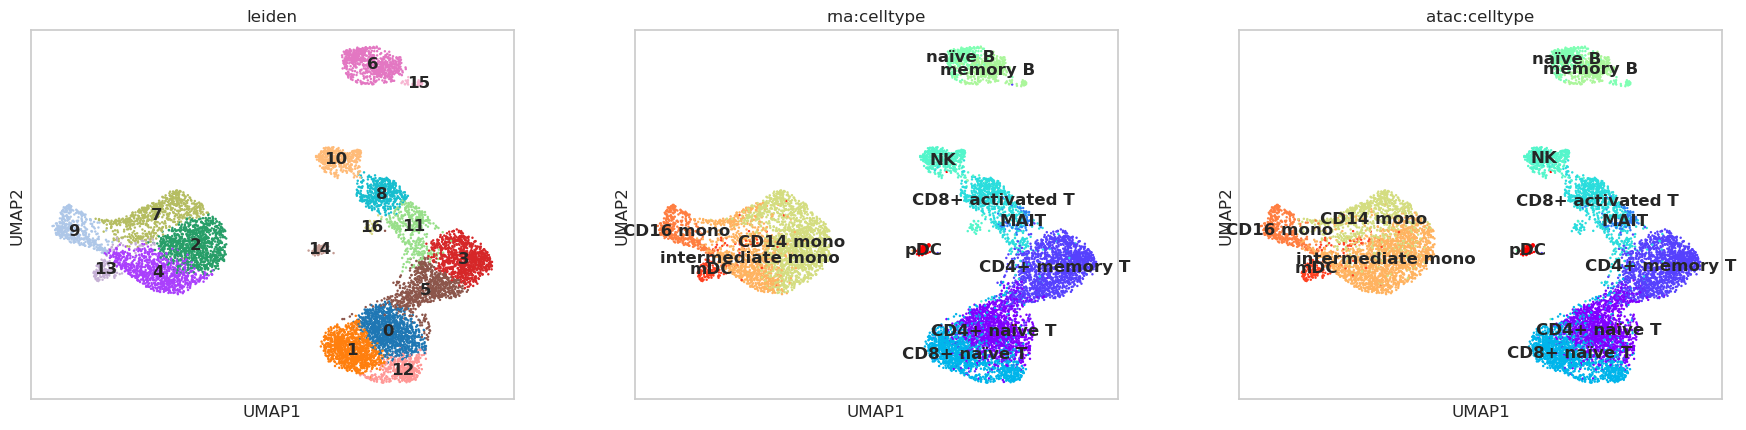

<IPython.core.display.Javascript object>

In [26]:
groupby = "leiden"
color = [groupby] + ["rna:celltype", "atac:celltype"]
muvi.pl.umap(model, color, legend_loc="on data")

The inferred latent space captures major axes of variation such as different cell types. Next, we look into specific factors (pathways) that explain variance within specific cell types. 

In [27]:
muvi.tl.rank(model, "rna:celltype", method="wilcoxon")

<IPython.core.display.Javascript object>

2023-05-31 17:24:59,837 - muvi.tools.plotting - WARNING - dendrogram data not found (using `dendrogram_rna:celltype` as key). Running `muvi.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `muvi.tl.dendrogram` independently.


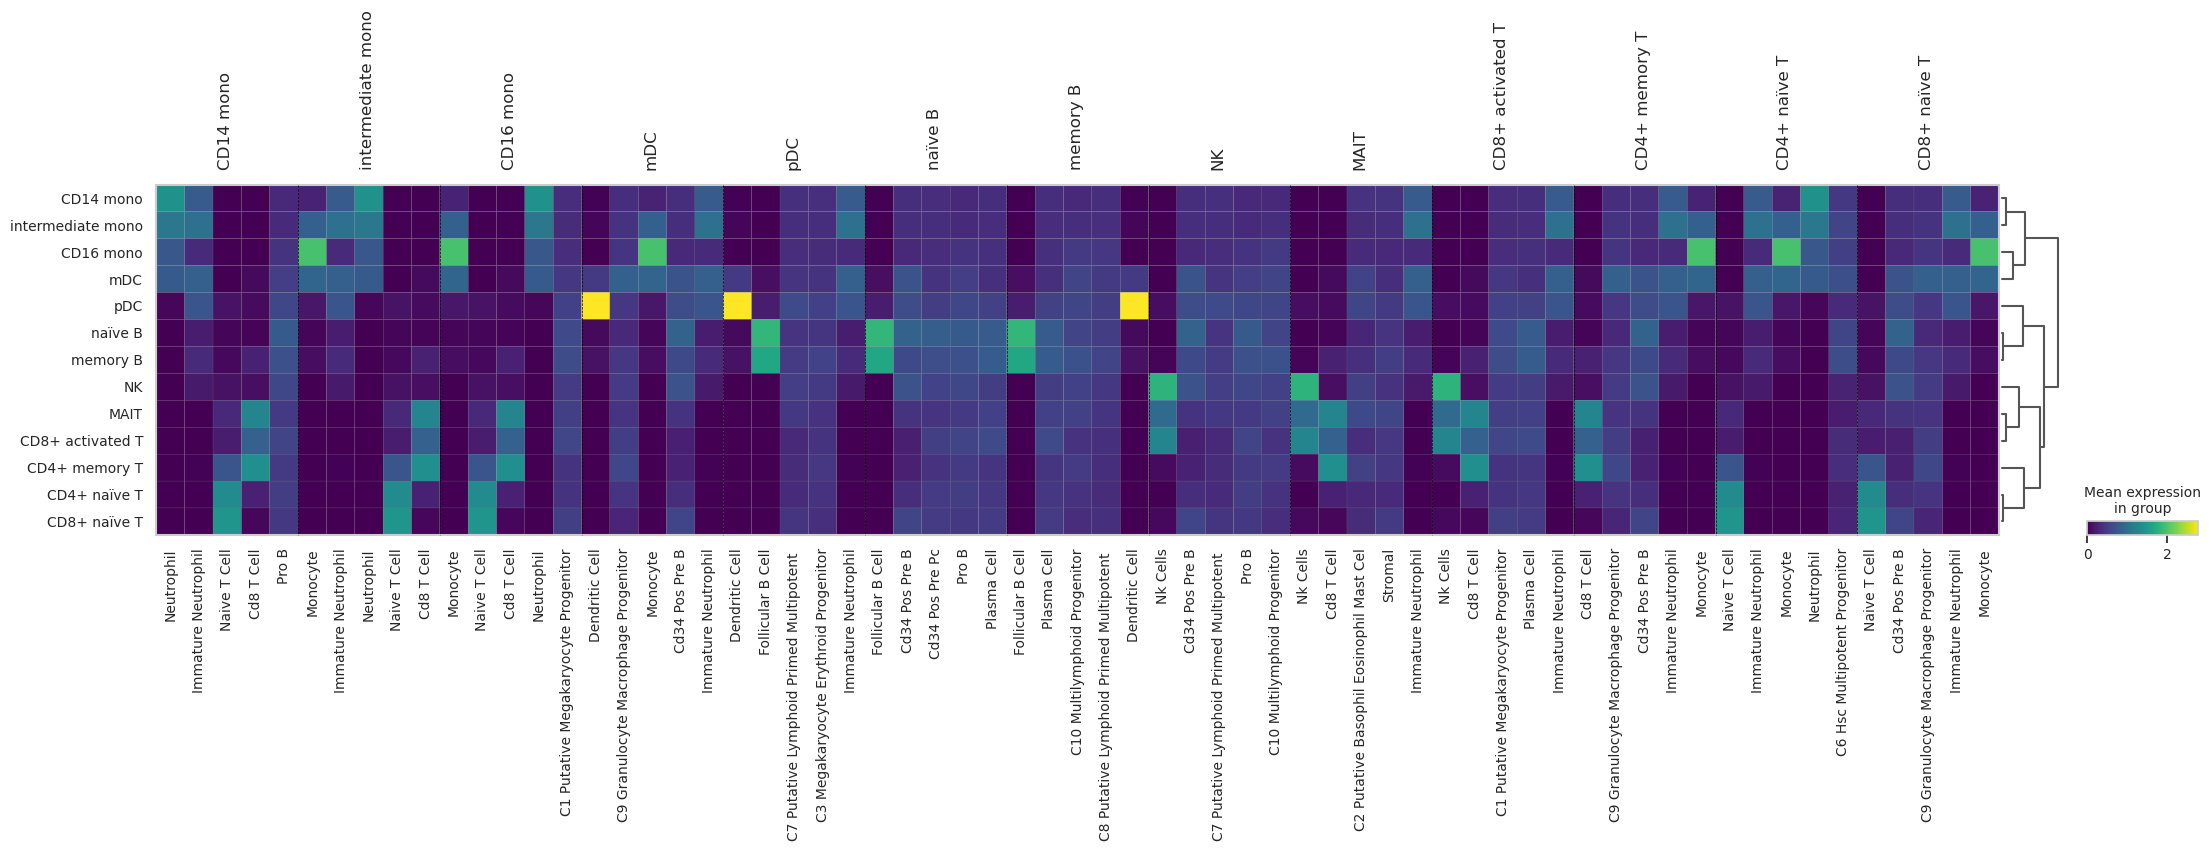

<AxesSubplot: >

<IPython.core.display.Javascript object>

In [28]:
muvi.pl.rank(model, n_factors=5, pl_type="matrixplot")

In [29]:
relevant_factors = []

<IPython.core.display.Javascript object>

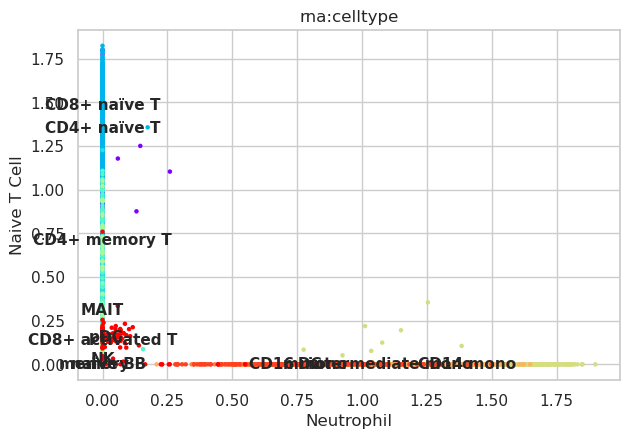

<IPython.core.display.Javascript object>

In [30]:
# top two factors explaining variance in the monocytes and separating them from the other cells
top_r2_factors = ["Neutrophil", "Naive T Cell"]
relevant_factors += top_r2_factors
muvi.pl.scatter(
    model,
    *top_r2_factors,
    "rna:celltype",
    size=42,
    legend_loc="on data",
)

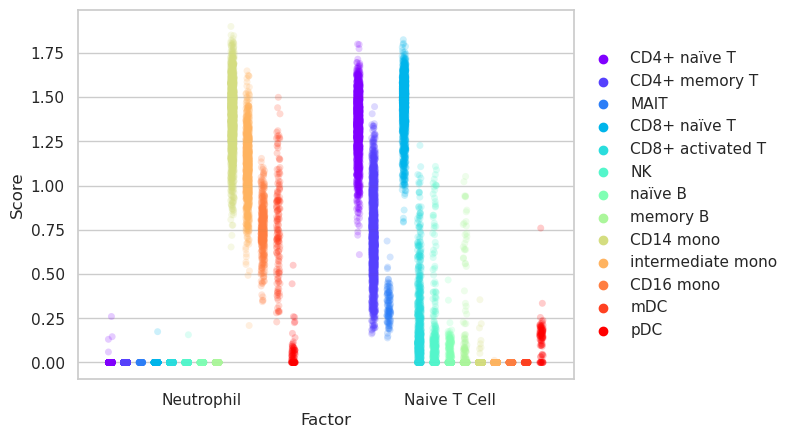

<AxesSubplot: xlabel='Factor', ylabel='Score'>

<IPython.core.display.Javascript object>

In [31]:
# stripplots are much more suitable than scatterplots for non-negative results
muvi.pl.stripplot(
    model,
    top_r2_factors,
    "rna:celltype",
    rot=0,
    alpha=0.2,
)

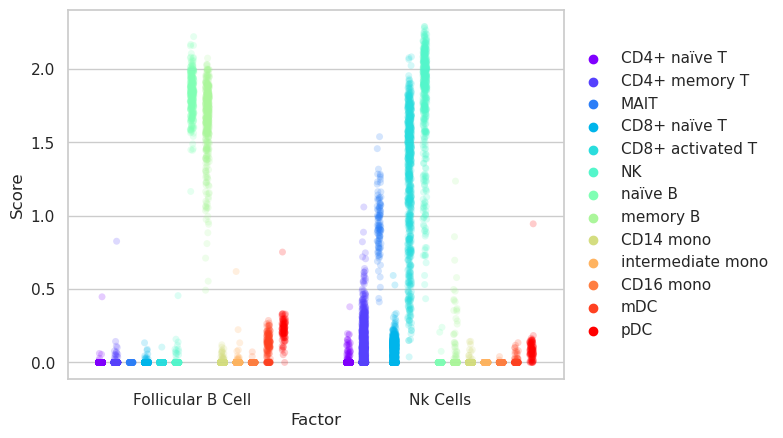

<AxesSubplot: xlabel='Factor', ylabel='Score'>

<IPython.core.display.Javascript object>

In [32]:
# pathways relevant for B cells and NK cells
top_bnk_factors = ["Follicular B Cell", "Nk Cells"]
relevant_factors += top_bnk_factors
muvi.pl.stripplot(
    model,
    top_bnk_factors,
    "rna:celltype",
    rot=0,
    alpha=0.2,
)

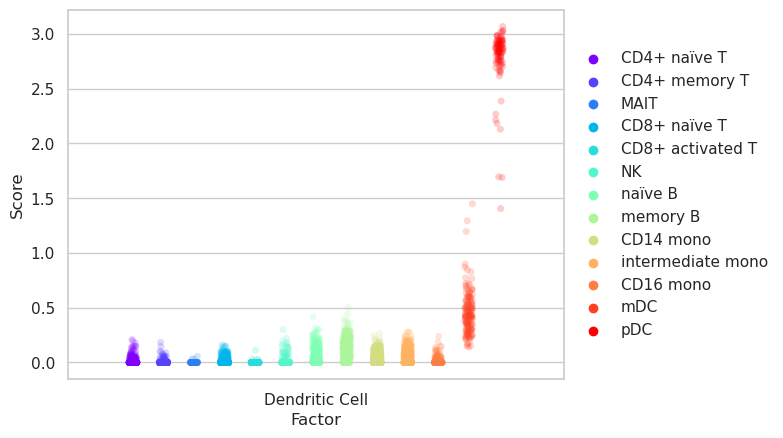

<AxesSubplot: xlabel='Factor', ylabel='Score'>

<IPython.core.display.Javascript object>

In [33]:
# pathways relevant for mDCs and pDCs
top_dc_factors = ["Dendritic Cell"]
relevant_factors += top_dc_factors
muvi.pl.stripplot(
    model,
    top_dc_factors,
    "rna:celltype",
    rot=0,
    alpha=0.2,
)

In [34]:
groups = [
    "CD14 mono",
    "intermediate mono",
    "CD16 mono",
    "naïve B",
    "memory B",
    "mDC",
    "pDC",
    "NK",
]

<IPython.core.display.Javascript object>

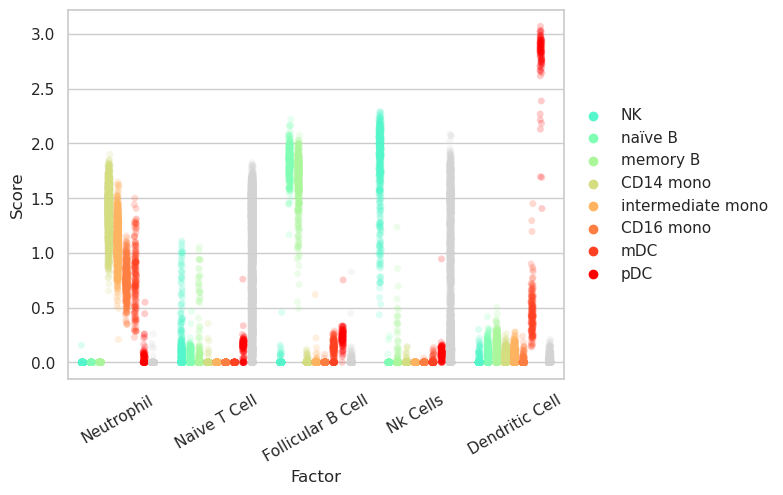

<AxesSubplot: xlabel='Factor', ylabel='Score'>

<IPython.core.display.Javascript object>

In [35]:
muvi.pl.stripplot(
    model,
    relevant_factors,
    "rna:celltype",
    groups=groups,
    rot=30,
    alpha=0.2,
)

We may also compute the group-wise variance explained across all cell types.

In [36]:
_ = muvi.tl.variance_explained_grouped(model, "rna:celltype")

<IPython.core.display.Javascript object>

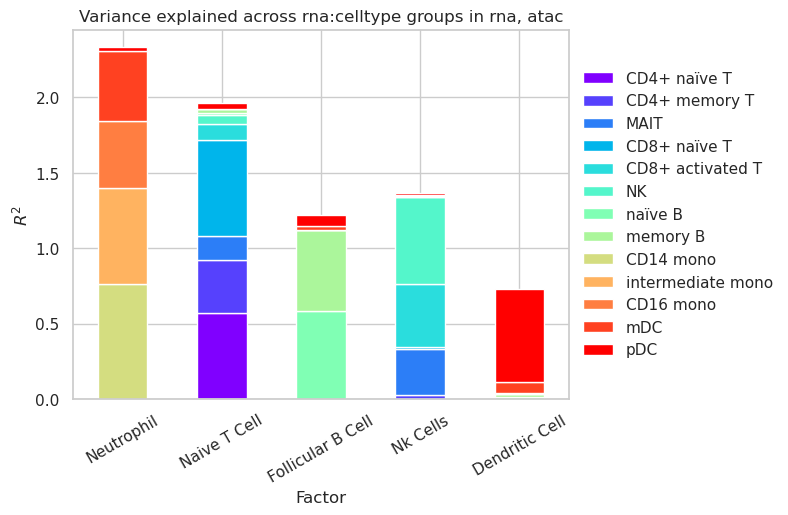

<AxesSubplot: title={'center': 'Variance explained across rna:celltype groups in rna, atac'}, xlabel='Factor', ylabel='$R^2$'>

<IPython.core.display.Javascript object>

In [37]:
muvi.pl.variance_explained_grouped(model, relevant_factors, stacked=True, rot=30)

We may add a new metadata column for relevant cell types vs the rest and recompute the variance explained across the new groups.

In [38]:
celltypes = muvi.tl.get_metadata(model, "rna:celltype")
celltypes = celltypes.cat.add_categories("other")
celltypes[
    ~celltypes.isin(
        [
            "CD4+ naïve T",
            "CD4+ memory T",
            "MAIT",
            "CD8+ naïve T",
            "CD8+ activated T",
        ]
    )
] = "other"
_ = muvi.tl.add_metadata(model, "T cells vs rest", celltypes)

<IPython.core.display.Javascript object>

In [39]:
_ = muvi.tl.variance_explained_grouped(model, "T cells vs rest")

<IPython.core.display.Javascript object>

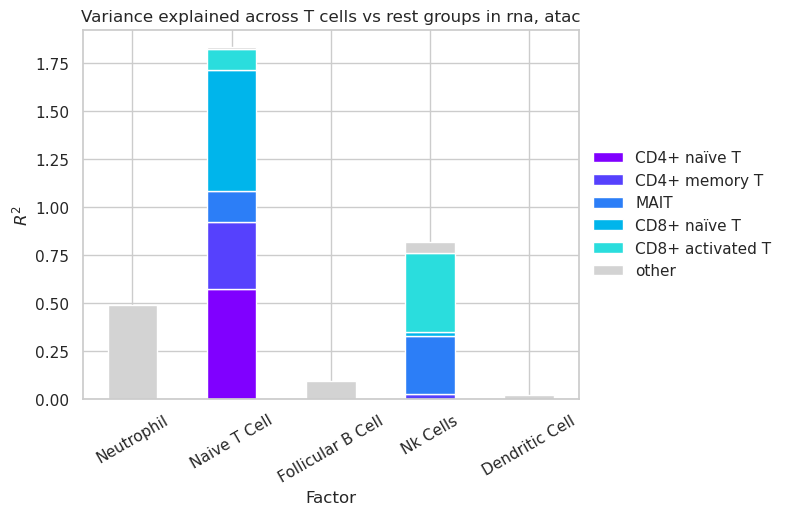

<AxesSubplot: title={'center': 'Variance explained across T cells vs rest groups in rna, atac'}, xlabel='Factor', ylabel='$R^2$'>

<IPython.core.display.Javascript object>

In [40]:
muvi.pl.variance_explained_grouped(
    model,
    relevant_factors,
    stacked=True,
    color=muvi.pl._get_color_dict(model._cache.factor_adata, "rna:celltype", "other"),
    rot=30,
)

To inspect a single factor in a single view regarding its factors loadings, simply call `muvi.pl.inspect_factor`. The features originating from the prior gene set annotation are shown as annotated (black), whereas the new features added during training are shown as inferred (red). As a result, we obtain a data-driven refinement of the prior feature sets.

Optionally, we can map peaks to gene symbols for better readability. Mapping file [pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv](https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv) downloaded from 10x Genomics.

In [41]:
atac_df = pd.read_csv(
    "pbmc_granulocyte_sorted_10k_atac_peak_annotation.tsv", sep="\t", index_col=0
)
atac_df["gene"] = atac_df["gene"].str.split(";").str[0]
s = atac_df.index.str.split("_")
atac_df.index = s.str[0] + ":" + s.str[1] + "-" + s.str[2]
mapping_dict = {k: f"{k[:10]}.. ({v})" for k, v in atac_df["gene"].to_dict().items()}
# mapping_dict
model.feature_names["atac"] = mdata["atac"].var_names.map(mapping_dict)

<IPython.core.display.Javascript object>

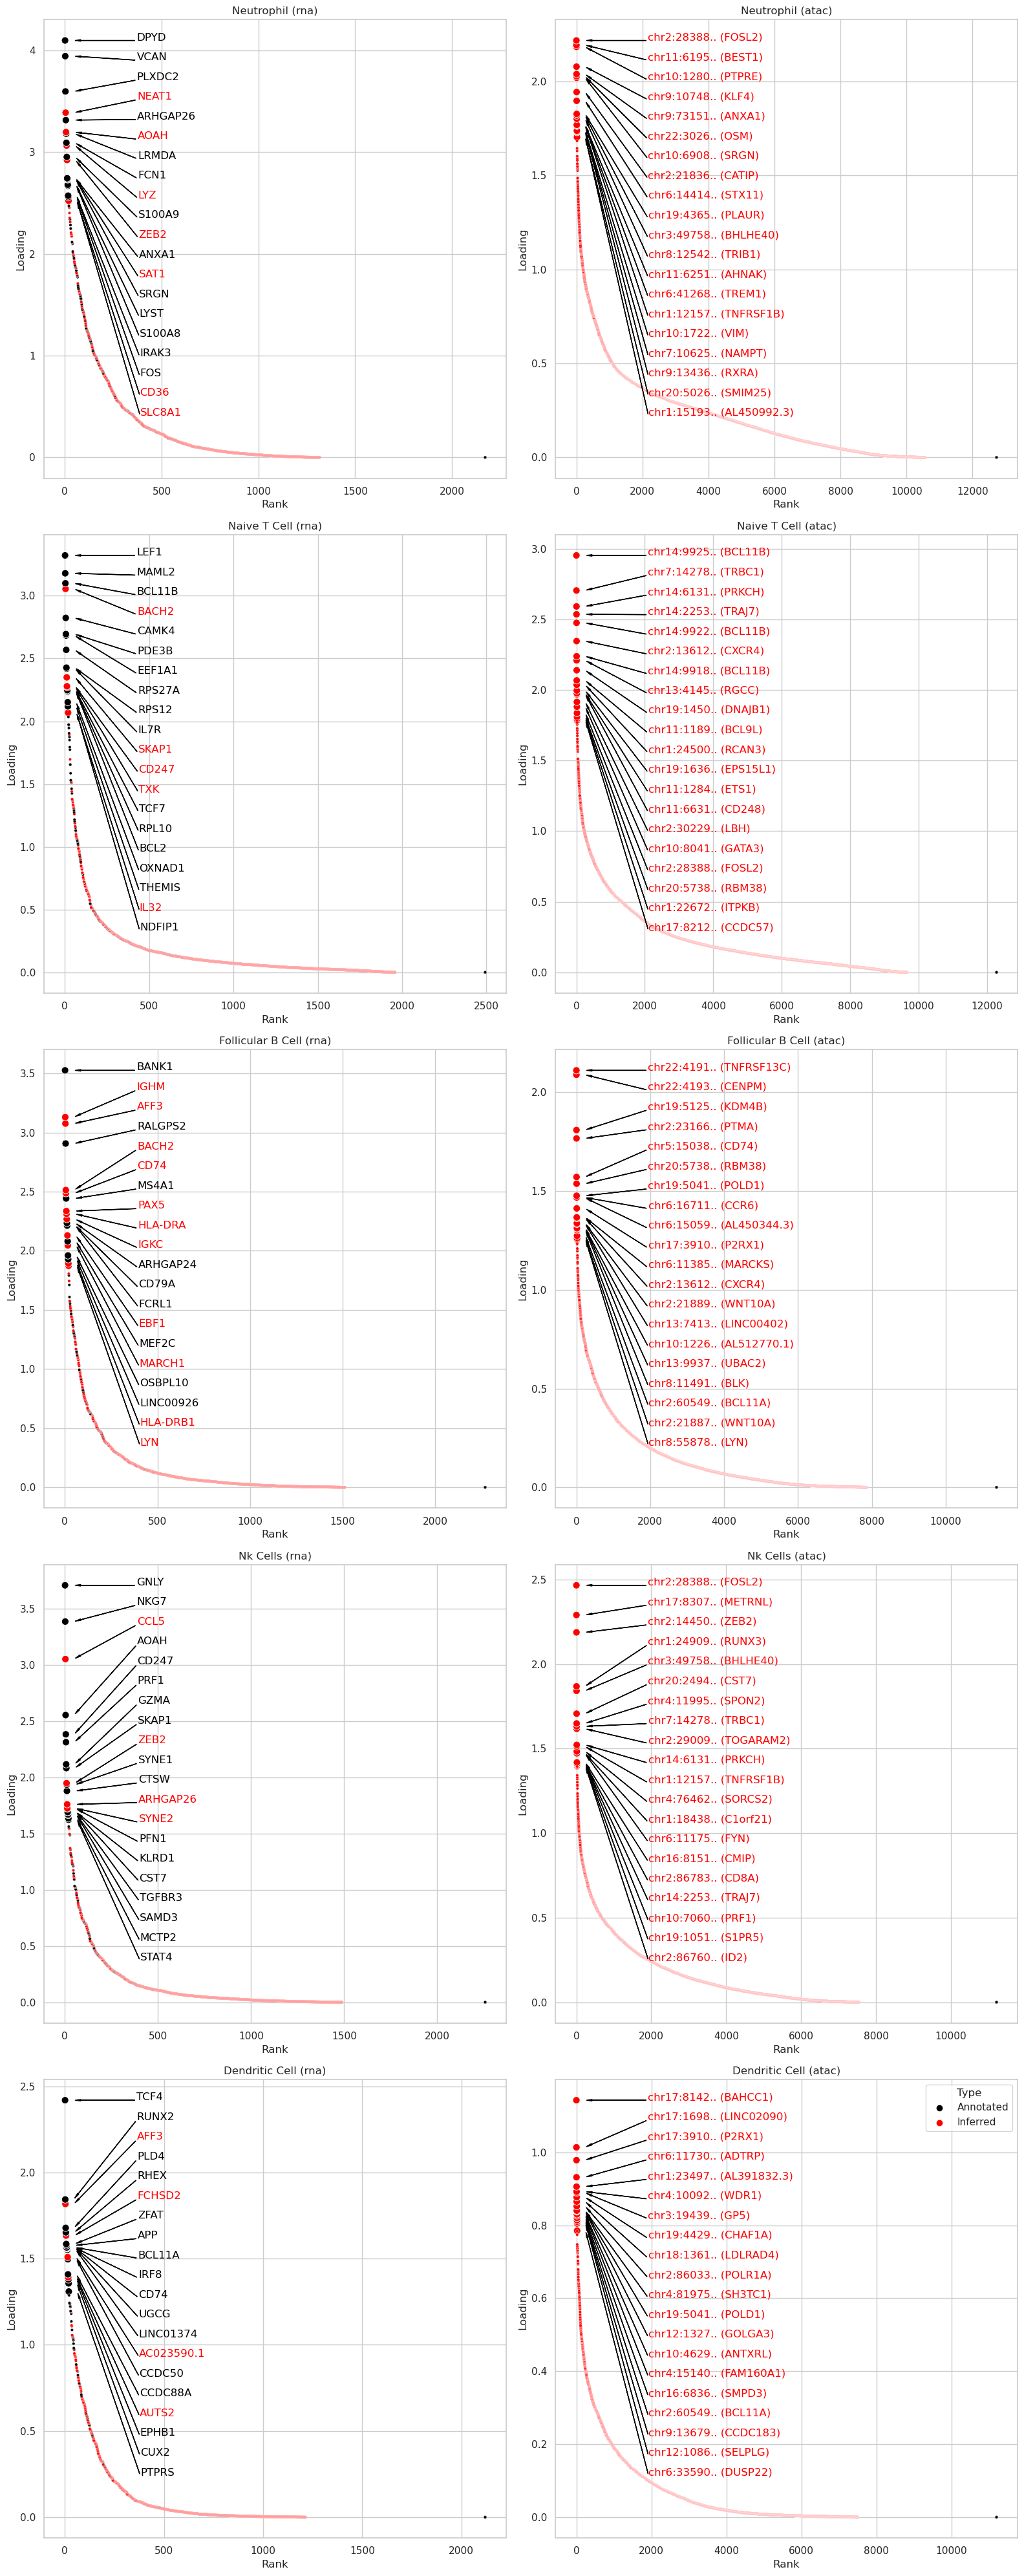

(<Figure size 1600x4000 with 10 Axes>,
 array([[<AxesSubplot: title={'center': 'Neutrophil (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <AxesSubplot: title={'center': 'Neutrophil (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'Naive T Cell (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <AxesSubplot: title={'center': 'Naive T Cell (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'Follicular B Cell (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <AxesSubplot: title={'center': 'Follicular B Cell (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'Nk Cells (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <AxesSubplot: title={'center': 'Nk Cells (atac)'}, xlabel='Rank', ylabel='Loading'>],
        [<AxesSubplot: title={'center': 'Dendritic Cell (rna)'}, xlabel='Rank', ylabel='Loading'>,
         <AxesSubplot: title={'center': 'Dendritic Cell (atac)'}, xlabel='Rank',

<IPython.core.display.Javascript object>

In [42]:
muvi.pl.inspect_factor(
    model,
    relevant_factors,
    top=20,
)